In [775]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import string
import sqlite3
import matplotlib.pyplot as plt
import datetime
from math import isnan
conn = sqlite3.connect('./zippedData/im.db')
TheNumbers = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [776]:
punct = '$,'   # `|` is not present here
money_to_num = str.maketrans(dict.fromkeys(punct, ''))

#stripping dollar-sign and commas from relevant objects
TheNumbers['worldwide_gross'] = '|'.join(TheNumbers['worldwide_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['domestic_gross'] = '|'.join(TheNumbers['domestic_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['production_budget'] = '|'.join(TheNumbers['production_budget'].tolist()).translate(money_to_num).split('|')
#converting number strings to int64 types
TheNumbers['worldwide_gross'] = TheNumbers['worldwide_gross'].astype(np.int64)
TheNumbers['domestic_gross'] = TheNumbers['domestic_gross'].astype(np.int64)
TheNumbers['production_budget'] = TheNumbers['production_budget'].astype(np.int64)
#convert release date to a datetime
TheNumbers['release_date'] = pd.to_datetime(TheNumbers['release_date'])


#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

### New Metrics created for TheNumbers
- domestic_profit
- worldwide_profit
- domestic_margin
- worldwide_margin

In [777]:
#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

### Production budget vs genre
- Create a dataframe that takes all of the production_budget info in from TheNumbers, and then is able to assign genres from IMDB. Connect the movie names to their genres.
- Group the genres and chart vs total budget, profit, margins

In [778]:
query = '''
SELECT
    primary_title,
    genres,
    start_year
FROM
    movie_basics
    '''
movie_genre = pd.read_sql(query, conn)

#### Clean genres into a list. Set movie name as index.

In [779]:
movie_genre['genres_list'] = movie_genre['genres'].str.split()

#### Some movie's have identical names. Make a new 'name_year' column to join on for both datasets.

In [780]:
movie_genre['name_year'] = movie_genre['primary_title'] + movie_genre['start_year'].apply(str)

In [781]:
# TheNumbers['release_date'] is a datetime64[ns]
year = TheNumbers['release_date'].dt.year
TheNumbers['name_year'] = TheNumbers['movie']+ TheNumbers['release_date'].dt.strftime('%Y')

In [782]:
# Set name_year as index
movie_genre.set_index('name_year', inplace=True)

,primary_title,genres,start_year,genres_list
name_year,,,,
Sunghursh2013,Sunghursh,"Action,Crime,Drama",2013,"[Action,Crime,Drama]"
One Day Before the Rainy Season2019,One Day Before the Rainy Season,"Biography,Drama",2019,"[Biography,Drama]"
The Other Side of the Wind2018,The Other Side of the Wind,Drama,2018,[Drama]
Sabse Bada Sukh2018,Sabse Bada Sukh,"Comedy,Drama",2018,"[Comedy,Drama]"
The Wandering Soap Opera2017,The Wandering Soap Opera,"Comedy,Drama,Fantasy",2017,"[Comedy,Drama,Fantasy]"


In [783]:
# Remove movies without genre
movie_genre.dropna(subset=['genres_list'], inplace=True)

#### Join movie_genre with TheNumbers

In [784]:
money_genre = TheNumbers.join(movie_genre, on='name_year', how = 'inner')

## Some additional cleaning and outlier removal

#### Remove movies that had 0 domestic and worldwide gross 

In [785]:
money_genre = money_genre[(money_genre.domestic_gross != 0) & (money_genre.worldwide_gross != 0)]

#### Get all unique genres

In [787]:
genres = money_genre['genres'].unique().tolist()

In [788]:
unique_genres = []
for x in genres:
    templist = x.split(",")
    for y in templist:
        unique_genres.append(y)
unique_genres = list(set(unique_genres))

In [790]:
# genres_df is dict where key = genre, value = df of movies with that genre
genres_df = {x: money_genre[money_genre.genres.str.contains(x)] for x in unique_genres}

## Chart production costs vs revenue for each genre
#### Note:
- The IMDB database only has movies since 2010. Any older movies are excluded.


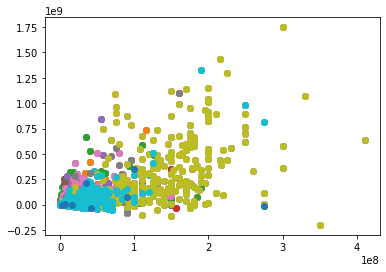

In [792]:
fig = plt.figure()
ax = plt.subplot(111)


for genre,frame in genres_df.items():
    ax = plt.scatter(frame['production_budget'], frame['worldwide_profit'], label=genre)

# ax.legend()
# ax.xlabel('production_budget')
# ax.ylabel('worldwide_profit');

In [800]:
money_genre['production_budget'].corr(money_genre['worldwide_profit'])

0.6528359616947517

With a corr of 0.653, we can see that spending more on a movie's budget generally leads to greater returns in the form of worldwide profit.

I'd like to dig more into each genre, and each production cost bucket(low/med/high) to provide a single best answer for: "What is the most likely profitable movie genre based on a given budget?"

#### Find corr of production cost vs revenue for each genre
- Note: outliers are not excluded

In [793]:
genres_corr = {}
for genre,frame in genres_df.items():
    corr = frame['production_budget'].corr(frame['worldwide_profit'])
    genres_corr[genre] = corr
#     print(f"{genre}: has a corr of {corr}")

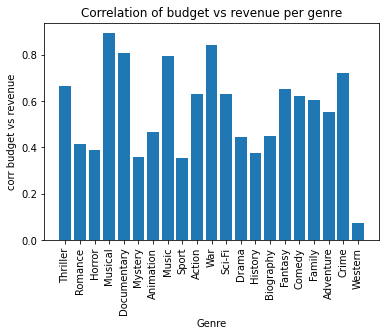

In [795]:
plt.bar(genres_corr.keys(), genres_corr.values())
plt.xticks(rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('corr budget vs revenue')
plt.title('Correlation of budget vs revenue per genre');

In [802]:
genres_df['Musical'].sort_values(['worldwide_profit'], ascending=False).head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin,name_year,primary_title,genres,start_year,genres_list
134,35,2017-03-17,Beauty and the Beast,160000000,504014165,1259199706,344014165,1099199706,0.682549,0.872935,Beauty and the Beast2017,Beauty and the Beast,"Family,Fantasy,Musical",2017,"[Family,Fantasy,Musical]"
50,51,2010-03-05,Alice in Wonderland,200000000,334191110,1025491110,134191110,825491110,0.401540,0.804971,Alice in Wonderland2010,Alice in Wonderland,"Fantasy,Musical",2010,"[Fantasy,Musical]"
524,25,2017-12-20,The Greatest Showman,84000000,174340174,386665550,90340174,302665550,0.518183,0.782758,The Greatest Showman2017,The Greatest Showman,"Biography,Drama,Musical",2017,"[Biography,Drama,Musical]"


#### Surprisingly, the musical genre has the greatest likelihood to convert budget to revenue.

We can now split every genre into low/med/high budget, and then graph their correlation of budget vs worldwide profit.

In [803]:
# Group low/med/high budget genres
# genres_df is dict where key = genre, value = df of movies with that genre
genres_df_low = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget < 5000000)] for x in unique_genres}
genres_df_med = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget > 5000000) & 
                                (money_genre.production_budget < 50000000)] for x in unique_genres}
genres_df_high = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget > 50000000)] for x in unique_genres}


Creating correlations for every budget bucket.
Note:
- Some outliers have been filtered out.
- Only genres with 3+ movies have been considered.

Musical only had 1 movies.
Animation only had 1 movies.
War only had 2 movies.
History only had 1 movies.
Western only had 2 movies.


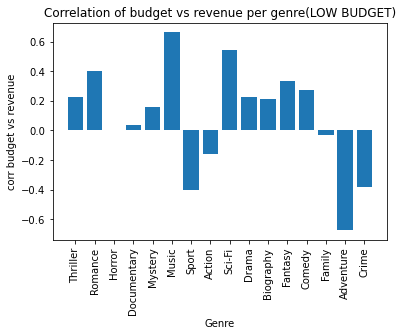

In [804]:
genres_corr_low = {}
for genre,frame in genres_df_low.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_low[genre] = corr
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")

clean_low = {k: genres_corr_low[k] for k in genres_corr_low if not isnan(genres_corr_low[k])}

    
plt.bar(clean_low.keys(), clean_low.values())
plt.xticks(rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('corr budget vs revenue')
plt.title('Correlation of budget vs revenue per genre(LOW BUDGET)');

Musical only had 2 movies.


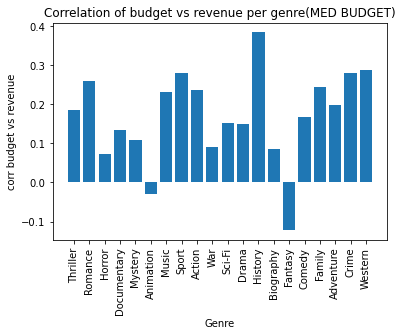

In [798]:
genres_corr_med = {}
for genre,frame in genres_df_med.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_med[genre] = corr
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")

plt.bar(genres_corr_med.keys(), genres_corr_med.values())
plt.xticks(rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('corr budget vs revenue')
plt.title('Correlation of budget vs revenue per genre(MED BUDGET)');

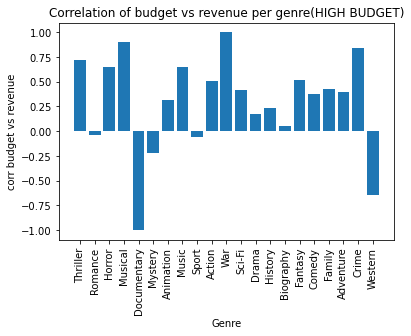

In [799]:
genres_corr_high = {}
for genre,frame in genres_df_high.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_high[genre] = corr
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")
        
        
plt.bar(genres_corr_high.keys(), genres_corr_high.values())
plt.xticks(rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('corr budget vs revenue')
plt.title('Correlation of budget vs revenue per genre(HIGH BUDGET)');

Based on these observations, we can now recommend genres that are most likely to generate profit from budget at stratified spending amounts.
- For a low budget production(sub 5 million dollars), we recommend creating a music movie.
- For a medium budget production(between 5 and 50 million dollars), we recommend creating a history movie.
- For a high budget production(over 50 million dollars), we recommend creating a war movie.
